In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
% matplotlib inline
import matplotlib
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import fully_connected

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.linewidth'] = 0.5
sns.set_style('whitegrid')

In [2]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

In [3]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [4]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [5]:
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [8]:
n_epochs = 100
batch_size = 150

In [10]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.906667 Test accuracy: 0.9299
1 Train accuracy: 0.933333 Test accuracy: 0.9246
2 Train accuracy: 0.98 Test accuracy: 0.9583
3 Train accuracy: 0.966667 Test accuracy: 0.9605
4 Train accuracy: 0.973333 Test accuracy: 0.9678
5 Train accuracy: 0.966667 Test accuracy: 0.9701
6 Train accuracy: 0.973333 Test accuracy: 0.9685
7 Train accuracy: 0.986667 Test accuracy: 0.9717
8 Train accuracy: 0.973333 Test accuracy: 0.9743
9 Train accuracy: 0.993333 Test accuracy: 0.9687
10 Train accuracy: 0.993333 Test accuracy: 0.9753
11 Train accuracy: 1.0 Test accuracy: 0.9702
12 Train accuracy: 0.993333 Test accuracy: 0.968
13 Train accuracy: 0.973333 Test accuracy: 0.9776
14 Train accuracy: 0.973333 Test accuracy: 0.9697
15 Train accuracy: 0.966667 Test accuracy: 0.9713
16 Train accuracy: 0.993333 Test accuracy: 0.9771
17 Train accuracy: 1.0 Test accuracy: 0.9765
18 Train accuracy: 0.993333 Test accuracy: 0.977
19 Train accuracy: 0.993333 Test accuracy: 0.9726
20 Train accuracy: 1.0 Tes

    3. Create a time series (see Fig 14-7 for an example).

RNN with Time Series

Data

In [2]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [3]:
ts_data = TimeSeriesData(250,0,10)

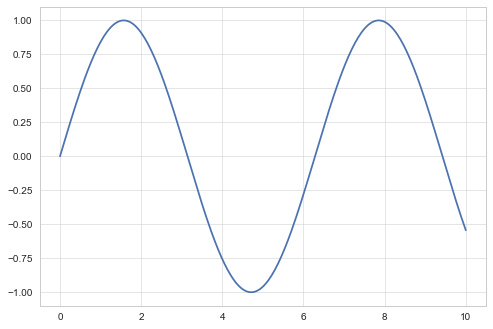

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

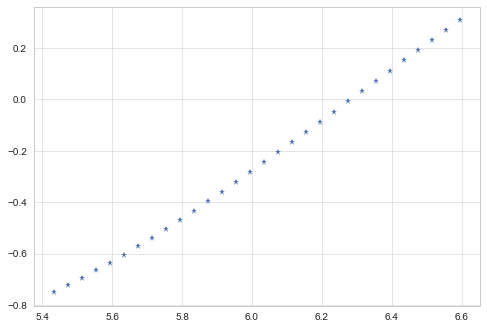

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

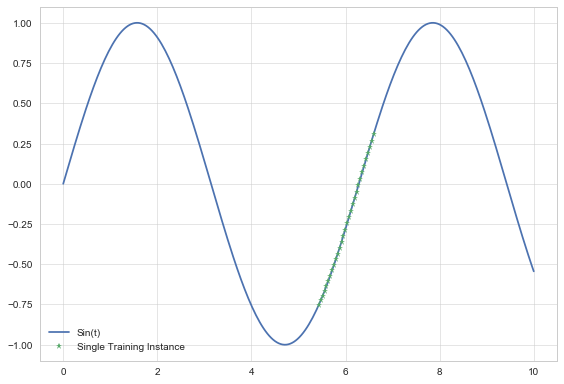

In [8]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

# A Training Instance and what to predict

We are trying to predict a time series shifted over by t+1

In [10]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

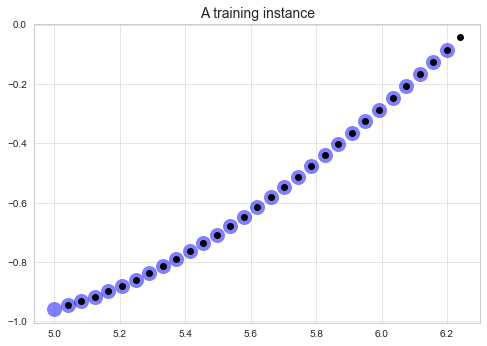

In [11]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

# Creating the Model

In [12]:
tf.reset_default_graph()

##### Constants

In [13]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

# Placeholders

In [14]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

## RNN Cell Layer

Play around with the various cells in this section, compare how they perform against each other.

In [15]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

#### Dynamic RNN Cell

In [16]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

#### Loss Function and Optimizer

In [17]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init Variables 

In [18]:
init = tf.global_variables_initializer()

# Session

In [19]:
saver = tf.train.Saver()

In [20]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 0.518102
100 	MSE: 0.0937219
200 	MSE: 0.179756
300 	MSE: 0.0415679
400 	MSE: 0.00427465
500 	MSE: 0.016875
600 	MSE: 0.0326605
700 	MSE: 0.0489346
800 	MSE: 0.024283
900 	MSE: 0.00381119
1000 	MSE: 0.0039935
1100 	MSE: 0.00237818
1200 	MSE: 0.00570009
1300 	MSE: 0.0173018
1400 	MSE: 0.0131922
1500 	MSE: 0.0162594
1600 	MSE: 0.00959082
1700 	MSE: 0.0124093
1800 	MSE: 0.00639059
1900 	MSE: 0.00520156


#### Predicting a time series t+1

In [21]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


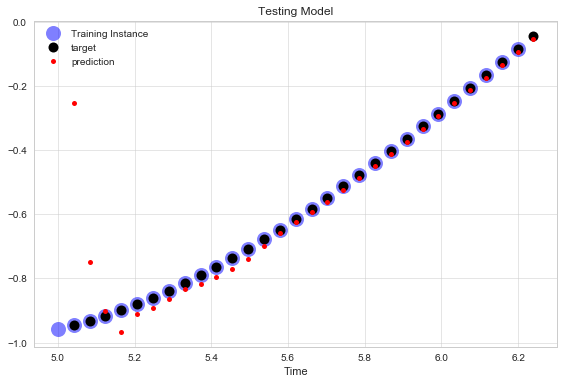

In [22]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating New Sequence

#### Note: Can give wacky results sometimes, like exponential growth

In [23]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


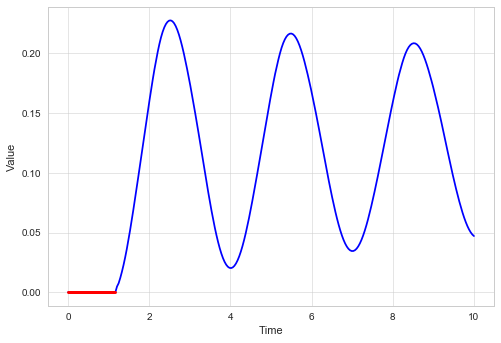

In [24]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(training_instance) -num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


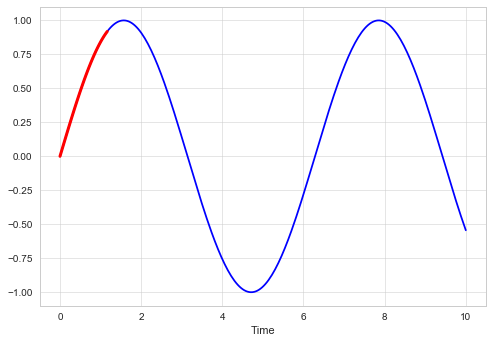

In [26]:
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")